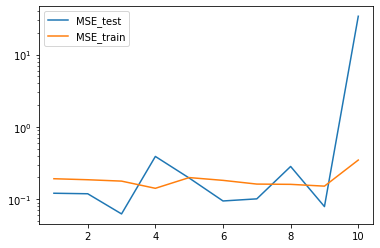

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as lm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


def prepare_data(X: np.ndarray, t: np.ndarray, test_size=0.2):
    # split in training and test data

    X_train, X_test, t_train, t_test = train_test_split(
        X, t, test_size=test_size)

    return X_train, X_test, t_train, t_test

def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4


def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

def noise_factor(n, factor=0.3):
    return factor*np.random.randn(n, n)  # Stochastic noise



# Making meshgrid of datapoints and compute Franke's function
np.random.seed(4155)
maxdegree = 10
n = 20
n_bootstraps = n - int(n/10)
x = np.sort(np.random.uniform(0, 1, n)) 
y = np.sort(np.random.uniform(0, 1, n))
x,y = np.meshgrid(x,y)
z = FrankeFunction(x,y) + 0.2*np.random.randn(n,n) 


# print(X.shape)
# print(z.shape)

# Hold out some test data that is never used in training.

n_bootstraps = n - int(n/10)
# The following (m x n_bootstraps) matrix holds the column vectors y_pred
# for each bootstrap iteration.
MSE_test = np.zeros(maxdegree)
MSE_train = np.zeros(maxdegree)
for degree in range(1,maxdegree+1):
    
	X = create_X(x, y, maxdegree)
	z_flat = z.ravel().reshape(-1,1)
    
    

	x_train, x_test, t_train, t_test = train_test_split(X, z_flat, test_size=0.2)
 
	t_hat_trains = np.empty((t_train.shape[0], n_bootstraps))
	t_hat_tests = np.empty((t_test.shape[0], n_bootstraps))
 
	for i in range(n_bootstraps):
		x_, y_ = resample(x_train, t_train)
		model = lm.LinearRegression().fit(x_,y_)
		t_hat_train = model.predict(x_)		
		t_hat_test = model.predict(x_test)

		t_hat_trains[:, i] = t_hat_train.ravel()
		t_hat_tests[:, i] = t_hat_test.ravel()
	
	MSE_test[degree-1] = np.mean( np.mean((t_test - t_hat_test)**2, axis=1, keepdims=True))
	MSE_train[degree-1] = np.mean(np.mean((t_train - t_hat_train)**2, axis=1, keepdims=True))
plt.semilogy(np.arange(1,maxdegree+1), MSE_test, label="MSE_test")
plt.semilogy(np.arange(1,maxdegree+1), MSE_train,label="MSE_train")
# plt.ylim(0,5)
plt.legend()